<a href="https://colab.research.google.com/github/Prasanna717/Projects/blob/main/Prophet_practise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
%matplotlib inline

In [3]:
df = pd.read_csv('biker.csv')
df = df[['dteday', 'cnt']].dropna()

df['dteday'] = pd.to_datetime(df['dteday'])
df = df.set_index('dteday')

daily_df = df.resample('D').mean()
d_df = daily_df.reset_index().dropna()

d_df['date_index'] = d_df['dteday']
d_df['date_index'] = pd.to_datetime(d_df['date_index'])
d_df = d_df.set_index('date_index')

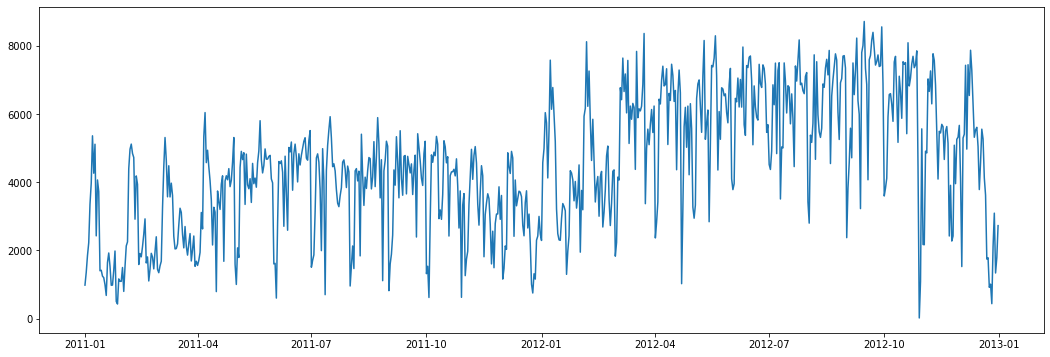

In [4]:
d_df.columns = ['ds', 'y']

fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(d_df.ds, d_df.y)

In [5]:
d_df.head()

,ds,y
date_index,,
2011-01-01,2011-01-01,985
2011-01-02,2011-01-02,1360
2011-01-03,2011-01-03,1851
2011-01-04,2011-01-04,2227
2011-01-05,2011-01-05,3351


In [6]:
d_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2011-01-01 to 2012-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      731 non-null    datetime64[ns]
 1   y       731 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 17.1 KB


In [7]:
d_df.tail(20)

,ds,y
date_index,,
2012-12-12,2012-12-12,5319
2012-12-13,2012-12-13,5532
2012-12-14,2012-12-14,5611
2012-12-15,2012-12-15,5047
2012-12-16,2012-12-16,3786
2012-12-17,2012-12-17,4585
2012-12-18,2012-12-18,5557
2012-12-19,2012-12-19,5267
2012-12-20,2012-12-20,4128


In [8]:

train = d_df.drop(d_df.index[-146:])
print(train.tail())

                   ds     y
date_index                 
2012-08-03 2012-08-03  5382
2012-08-04 2012-08-04  5169
2012-08-05 2012-08-05  5728
2012-08-06 2012-08-06  7736
2012-08-07 2012-08-07  4672


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 585 entries, 2011-01-01 to 2012-08-07
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      585 non-null    datetime64[ns]
 1   y       585 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.7 KB


In [122]:
from sklearn.model_selection import ParameterGrid
params_grid = {
               'fourier_order':[13,15,17,18],
               'prior_scale':[28,30,32],
               'n_changepoints':[200,250,300],
               'mode':['additive','multiplicative'],
               'changepoint_prior_scale':[0.05,0.09,0.1]
               }
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 216


In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import itertools

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [123]:
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    m1 = Prophet(weekly_seasonality=False, daily_seasonality=False, 
            yearly_seasonality=False, holidays_prior_scale=10,
            n_changepoints=p['n_changepoints'],
            changepoint_prior_scale=p['changepoint_prior_scale'])
    m1.add_seasonality(name='yearly', 
                                    period=365.25,
                                    fourier_order=p['fourier_order'],
                                    prior_scale=25,
                                    mode='multiplicative')
    m1.add_seasonality(name='month', period=30.5, fourier_order=55, prior_scale=20, mode=p['mode'])
    m1.add_seasonality(name="weekly", period=7, fourier_order=60, prior_scale=p['prior_scale'], mode='multiplicative')
    m1.add_seasonality(name="quaterly", period=91, fourier_order=15, prior_scale=10, mode='additive')
    m1.add_seasonality(name="half_yearly", period=182.5, fourier_order=10, prior_scale=7, mode='additive')
    m1.add_country_holidays(country_name='US')
    m1.fit(train)

    future = m1.make_future_dataframe(periods=200)

    forecast = m1.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)
    test=forecast[['ds','yhat']]
    Actual = d_df['y']
    MAPE = mean_absolute_percentage_error(Actual,abs(test['yhat'][0:731]))
    print('Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    model_parameters = model_parameters.append({'MAPE':MAPE,'Parameters':p},ignore_index=True)

{'changepoint_prior_scale': 0.05, 'fourier_order': 13, 'mode': 'additive', 'n_changepoints': 200, 'prior_scale': 28}
Mean Absolute Percentage Error(MAPE)------------------------------------ 51.80052122743525
{'changepoint_prior_scale': 0.05, 'fourier_order': 13, 'mode': 'additive', 'n_changepoints': 200, 'prior_scale': 30}
Mean Absolute Percentage Error(MAPE)------------------------------------ 51.4547857763682
{'changepoint_prior_scale': 0.05, 'fourier_order': 13, 'mode': 'additive', 'n_changepoints': 200, 'prior_scale': 32}
Mean Absolute Percentage Error(MAPE)------------------------------------ 51.882010742671206
{'changepoint_prior_scale': 0.05, 'fourier_order': 13, 'mode': 'additive', 'n_changepoints': 250, 'prior_scale': 28}
Mean Absolute Percentage Error(MAPE)------------------------------------ 51.670537181191854
{'changepoint_prior_scale': 0.05, 'fourier_order': 13, 'mode': 'additive', 'n_changepoints': 250, 'prior_scale': 30}
Mean Absolute Percentage Error(MAPE)--------------

In [124]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head(10)

,MAPE,Parameters
0,44.658698,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
1,44.765947,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
2,44.771951,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
3,44.793778,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
4,44.838131,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
5,44.900226,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
6,44.943824,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
7,45.005599,"{'changepoint_prior_scale': 0.1, 'fourier_orde..."
8,45.061581,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
9,45.130170,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."


In [24]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head(10)

,MAPE,Parameters
0,40.677996,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
1,40.722176,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
2,40.829069,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
3,40.871320,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
4,40.954435,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
5,40.967261,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
6,40.972195,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
7,40.972620,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
8,41.008234,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."
9,41.064454,"{'changepoint_prior_scale': 0.05, 'fourier_ord..."


In [ ]:
parameters = model_parameters.sort_values(by=['MAPE'])
parameters = parameters.reset_index(drop=True)
parameters.head(10)

,MAPE,Parameters
0,58.158393,"{'fourier_order': 7, 'prior_scale': 7}"
1,58.336256,"{'fourier_order': 8, 'prior_scale': 9}"
2,58.389753,"{'fourier_order': 3, 'prior_scale': 7}"
3,58.421647,"{'fourier_order': 9, 'prior_scale': 7}"
4,58.474462,"{'fourier_order': 4, 'prior_scale': 8}"
5,58.507432,"{'fourier_order': 9, 'prior_scale': 5}"
6,58.560719,"{'fourier_order': 6, 'prior_scale': 6}"
7,58.609014,"{'fourier_order': 4, 'prior_scale': 3}"
8,58.661509,"{'fourier_order': 4, 'prior_scale': 5}"
9,58.682384,"{'fourier_order': 3, 'prior_scale': 9}"


In [25]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.05,
 'fourier_order': 25,
 'mode': 'multiplicative',
 'n_changepoints': 250,
 'prior_scale': 15}

In [ ]:
parameters['Parameters'][0]

{'fourier_order': 3, 'holidays_prior_scale': 7, 'prior_scale': 6}

In [ ]:
parameters['Parameters'][2]

{'fourier_order': 3, 'holidays_prior_scale': 9, 'prior_scale': 6}

In [ ]:
parameters['Parameters'][3]

{'fourier_order': 4, 'prior_scale': 9}

In [148]:
m = Prophet(weekly_seasonality=False, daily_seasonality=False, 
            yearly_seasonality=False, holidays_prior_scale=10,
            changepoint_prior_scale=0.05, n_changepoints=250)
m.add_seasonality(name='yearly', 
                                    period=365.25,
                                    fourier_order=15,
                                    prior_scale=25,
                                    mode='multiplicative')
m.add_seasonality(name='month', period=30.5, fourier_order=55, prior_scale=20, mode='additive')
m.add_seasonality(name="weekly", period=7, fourier_order=60, prior_scale=30,mode='multiplicative')
m.add_seasonality(name="quaterly", period=91, fourier_order=6, prior_scale=10,mode='additive')
m.add_seasonality(name="half_yearly", period=182.5, fourier_order=10, prior_scale=7,mode='additive')
m.add_country_holidays(country_name='US')
m.fit(train)

future = m.make_future_dataframe(periods=200)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
770,2013-02-09,7193.279429,6079.076565,8261.852164
771,2013-02-10,6063.808005,4980.677859,7241.318759
772,2013-02-11,5757.482392,4643.269368,6805.809203
773,2013-02-12,6086.586312,5063.428872,7244.626924
774,2013-02-13,6478.012407,5388.515552,7506.154015
775,2013-02-14,6339.049867,5301.674826,7483.553982
776,2013-02-15,5970.497700,4910.798118,7136.094633
777,2013-02-16,5919.124402,4816.091092,7013.528254
778,2013-02-17,5412.717248,4341.062727,6485.845884
779,2013-02-18,5102.964260,4001.679210,6117.826726


<Figure size 1872x576 with 0 Axes>

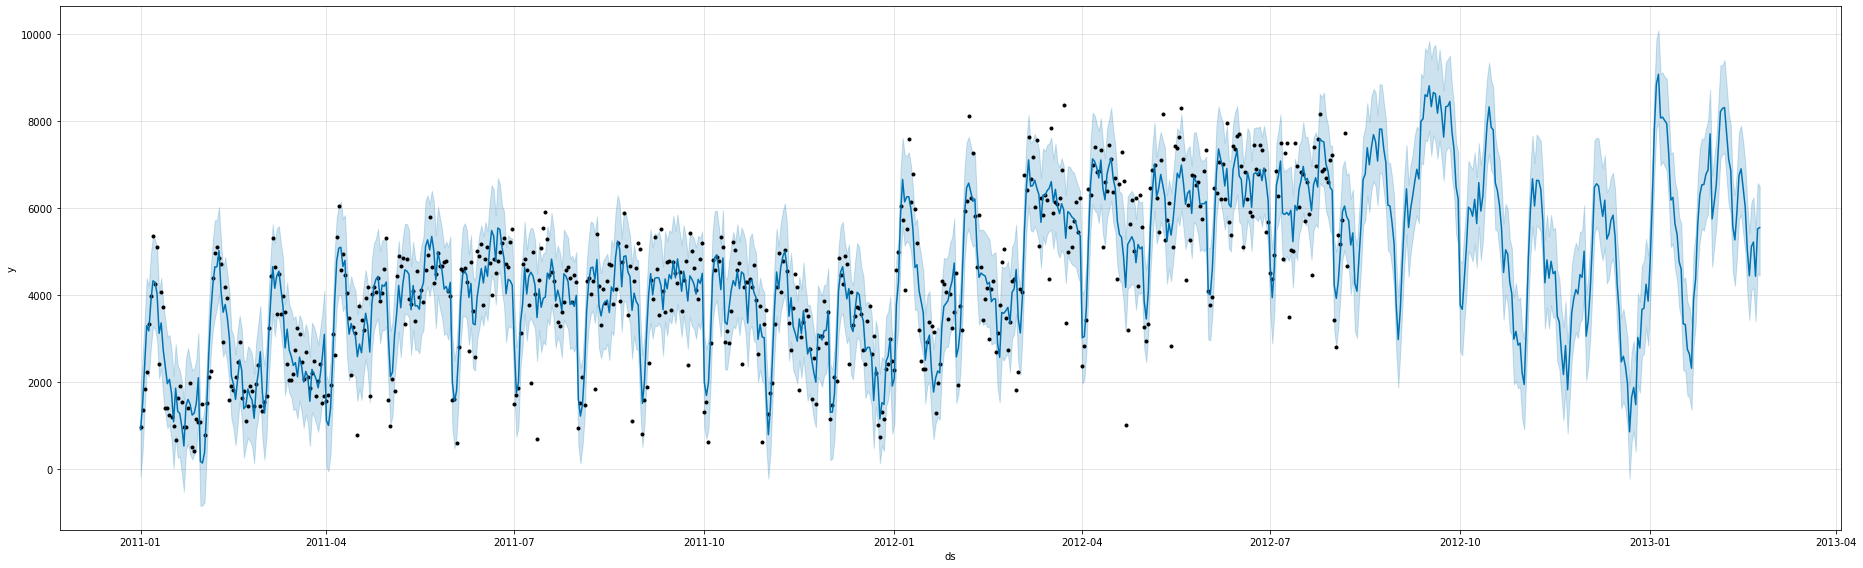

In [78]:
plt.figure(figsize=(26,8))
fig1 = m.plot(forecast,figsize=(26,8))

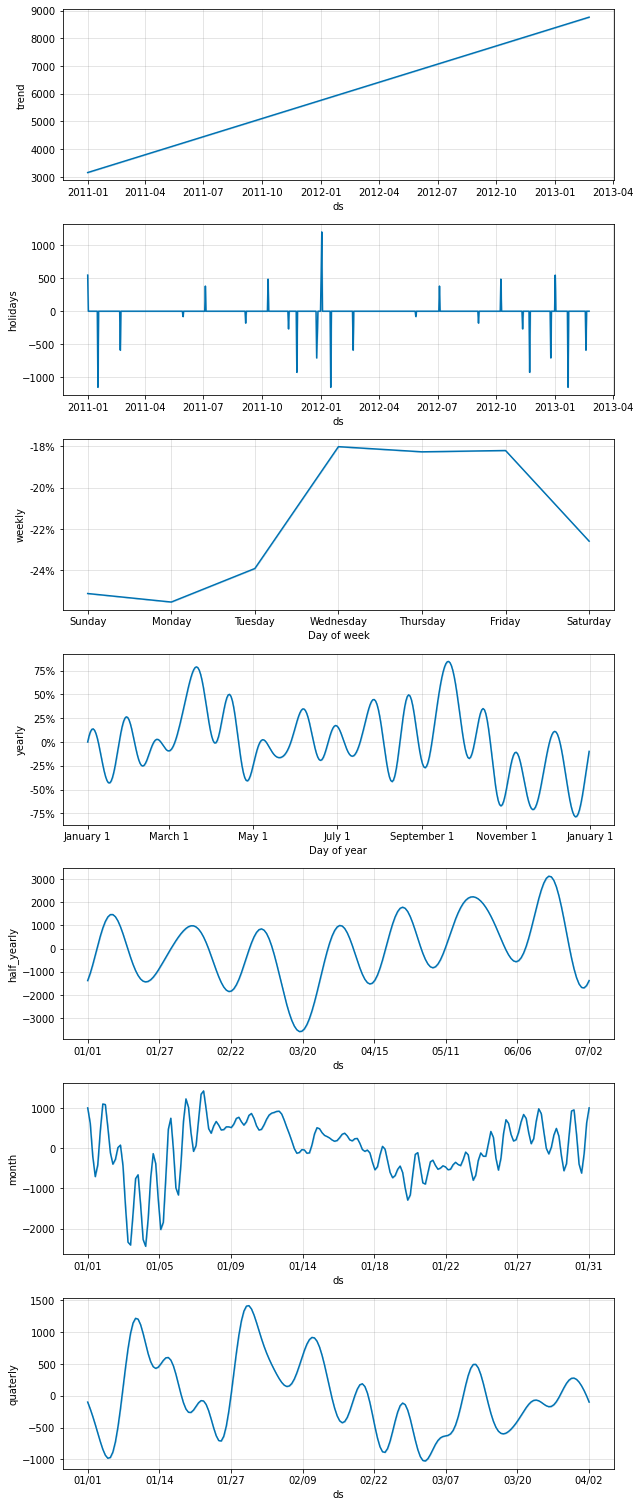

In [79]:
fig1 = m.plot_components(forecast)

In [149]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, initial='270 days', period='45 days', horizon = '90 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2011-11-11 00:00:00 and 2012-05-09 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,2.539144e+06,1593.469096,1325.671107,0.370996,0.256079,0.377778
1,10 days,2.574958e+06,1604.667712,1352.598779,0.375830,0.256593,0.355556
2,11 days,2.505184e+06,1582.777241,1308.980906,0.386985,0.256079,0.377778
3,12 days,2.700280e+06,1643.252915,1358.600577,0.399647,0.265339,0.400000
4,13 days,2.870065e+06,1694.126568,1420.175061,0.421702,0.266337,0.377778


In [150]:
mape_baseline = mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
mape_baseline

36.66428030514984

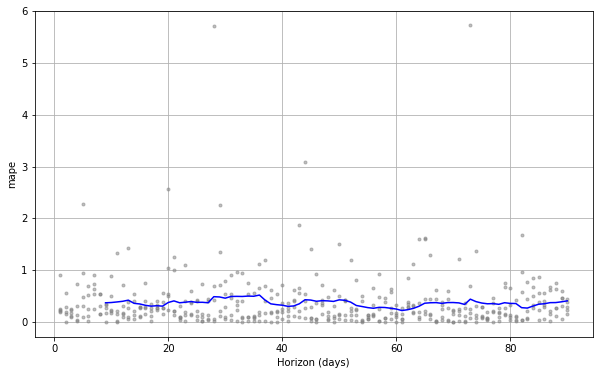

In [151]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [152]:

predictty = forecast['yhat'][0:585].values
Train = train['y'][:].values


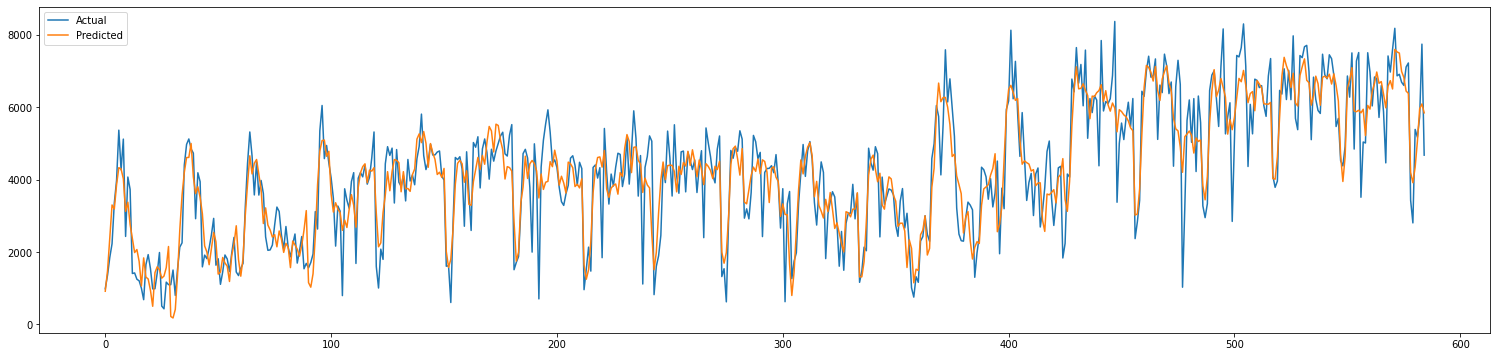

In [34]:
# 1st plot (11/5/2021)
# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(26, 6))
plt.plot(Train, label='Actual')
plt.plot(predictty, label='Predicted')
plt.legend()
plt.show()

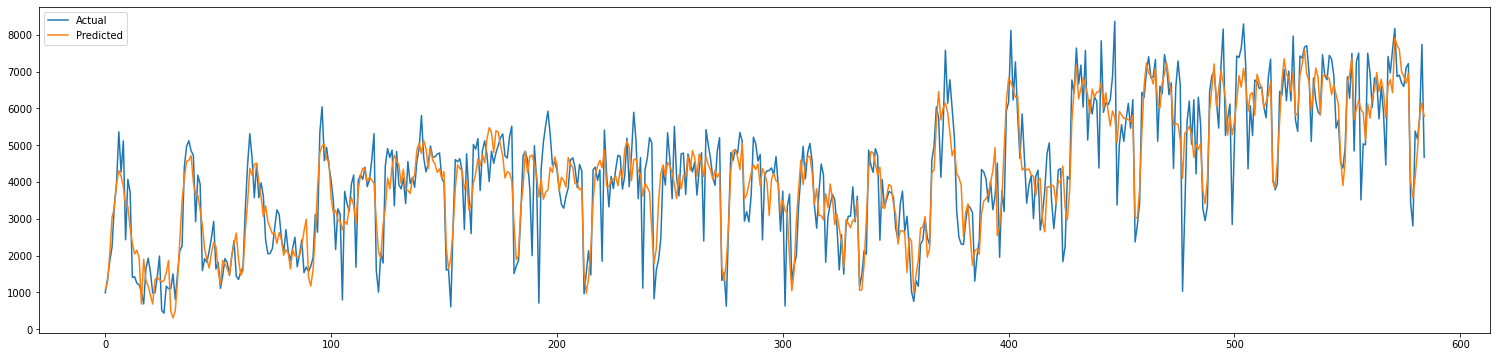

In [126]:
# 2nd plot (11/5/2021)
# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(26, 6))
plt.plot(Train, label='Actual')
plt.plot(predictty, label='Predicted')
plt.legend()

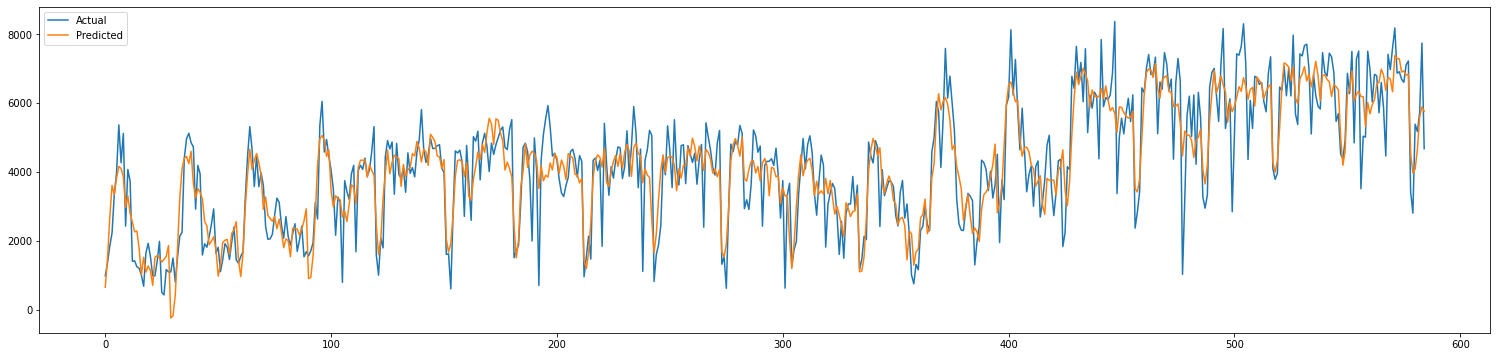

In [153]:
# 3rd plot (11/5/2021)
# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(26, 6))
plt.plot(Train, label='Actual')
plt.plot(predictty, label='Predicted')
plt.legend()

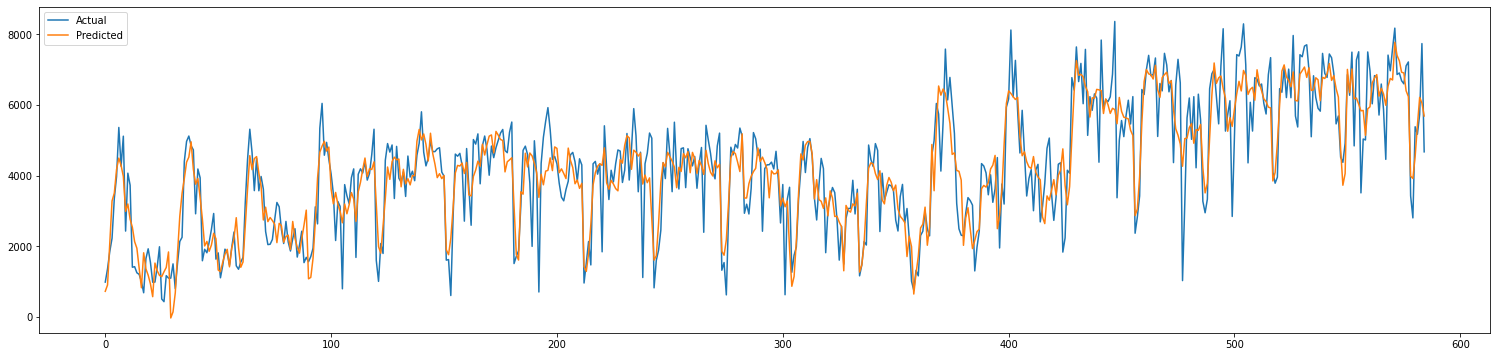

In [ ]:
#2nd plot
# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(26, 6))
plt.plot(Train, label='Actual')
plt.plot(predictty, label='Predicted')
plt.legend()
plt.show()

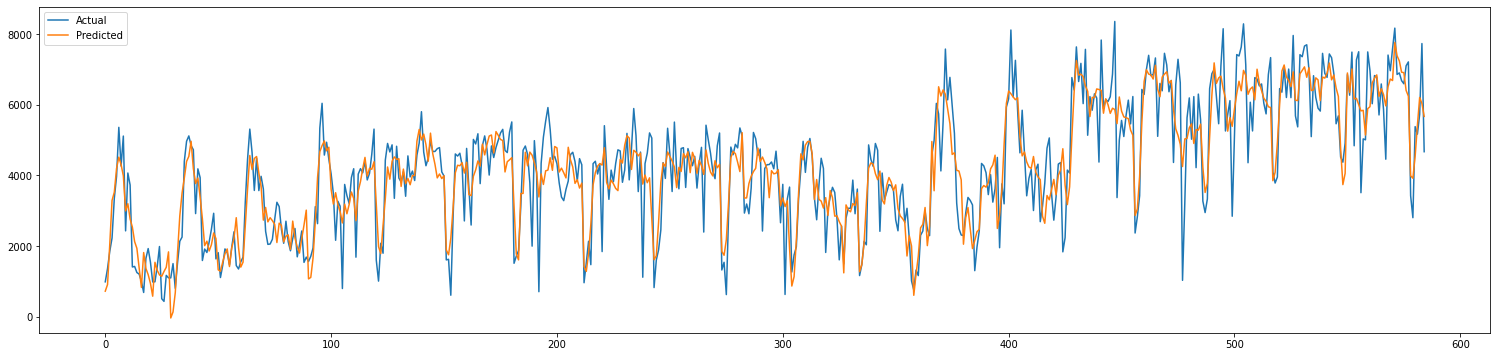

In [ ]:
#3rd plot
# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(26, 6))
plt.plot(Train, label='Actual')
plt.plot(predictty, label='Predicted')
plt.legend()
plt.show()

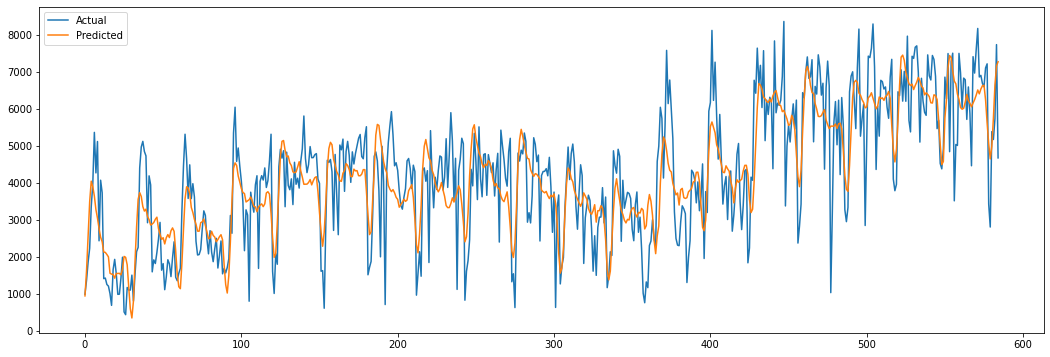

In [ ]:
# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(Train, label='Actual')
plt.plot(predictty, label='Predicted')
plt.legend()
plt.show()

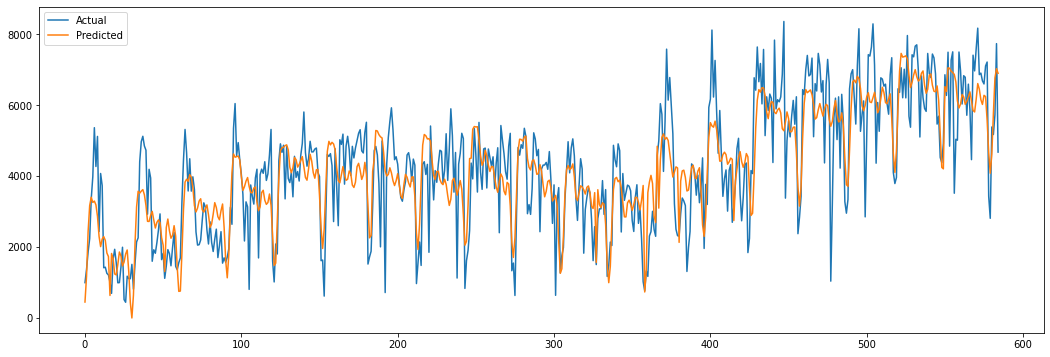

In [ ]:
# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(Train, label='Actual')
plt.plot(predictty, label='Predicted')
plt.legend()
plt.show()

train vs forecast till train

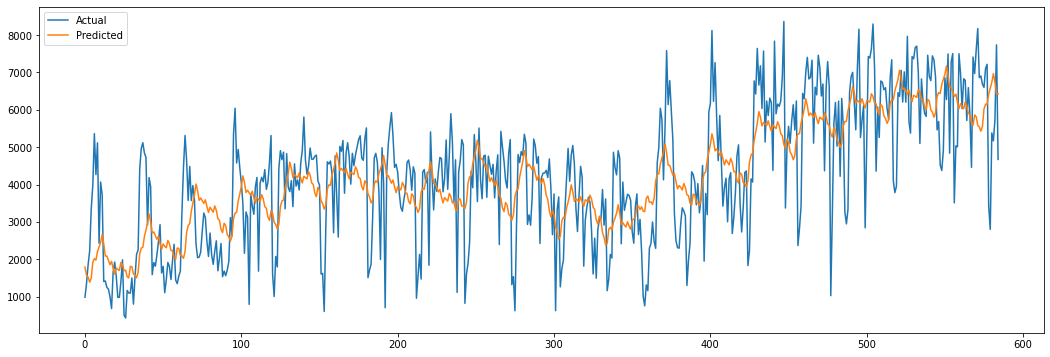

In [ ]:
# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(Train, label='Actual')
plt.plot(predictty, label='Predicted')
plt.legend()
plt.show()

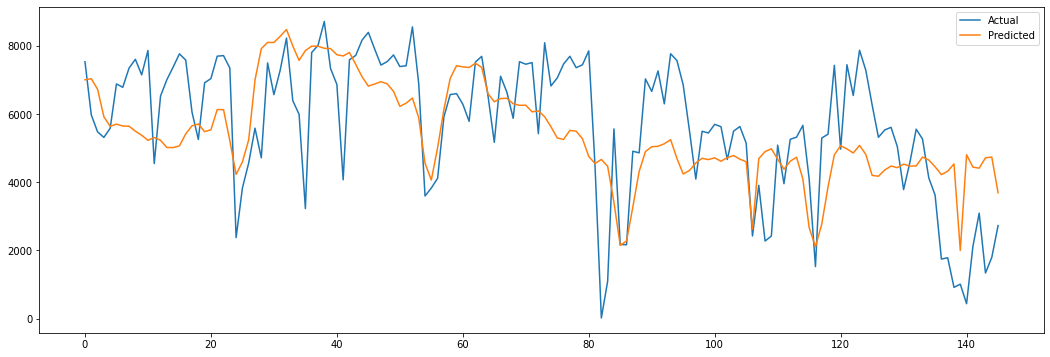

In [ ]:
y_true = d_df['y'][585:].values
y_pred = forecast['yhat'][585:731].values


# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

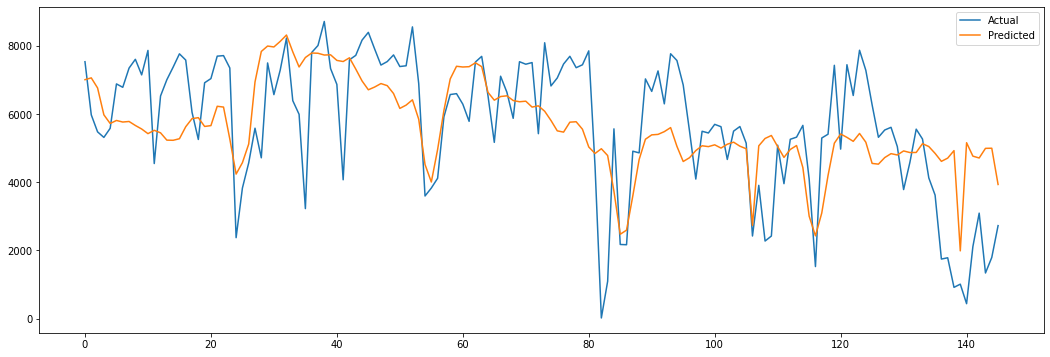

In [ ]:
y_true = d_df['y'][585:].values
y_pred = forecast['yhat'][585:731].values


# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

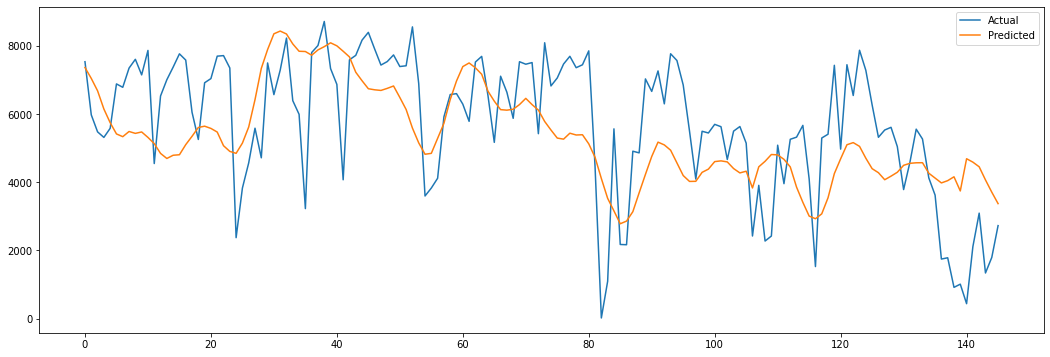

In [ ]:
y_true = d_df['y'][585:].values
y_pred = forecast['yhat'][585:731].values


# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

test vs forecast for test

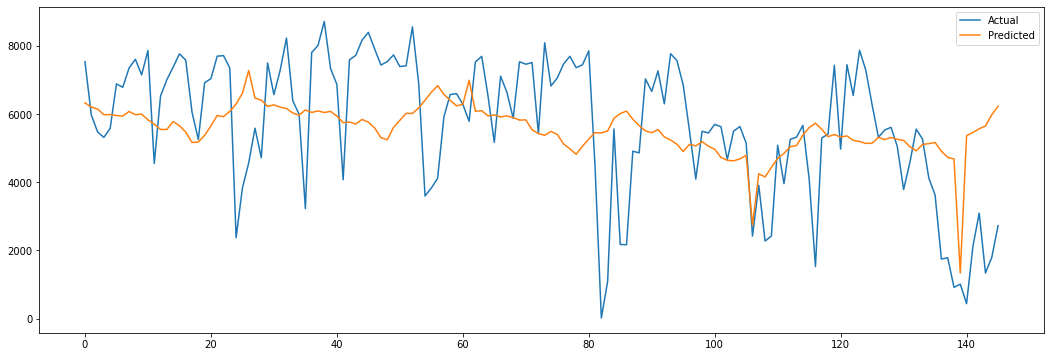

In [ ]:
y_true = d_df['y'][585:].values
y_pred = forecast['yhat'][585:731].values


# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

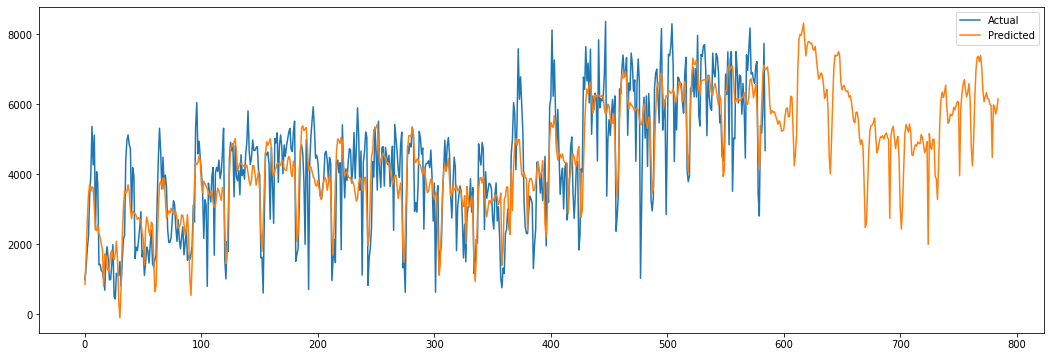

In [ ]:
predictivity = forecast['yhat'][:].values
Train = train['y'][:].values

# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(Train, label='Actual')
plt.plot(predictivity, label='Predicted')
plt.legend()
plt.show()

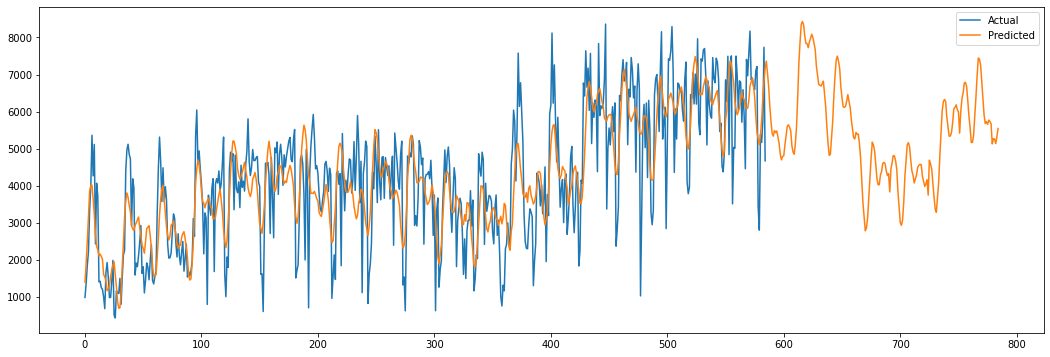

In [ ]:
predictivity = forecast['yhat'][:].values
Train = train['y'][:].values

# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(Train, label='Actual')
plt.plot(predictivity, label='Predicted')
plt.legend()
plt.show()

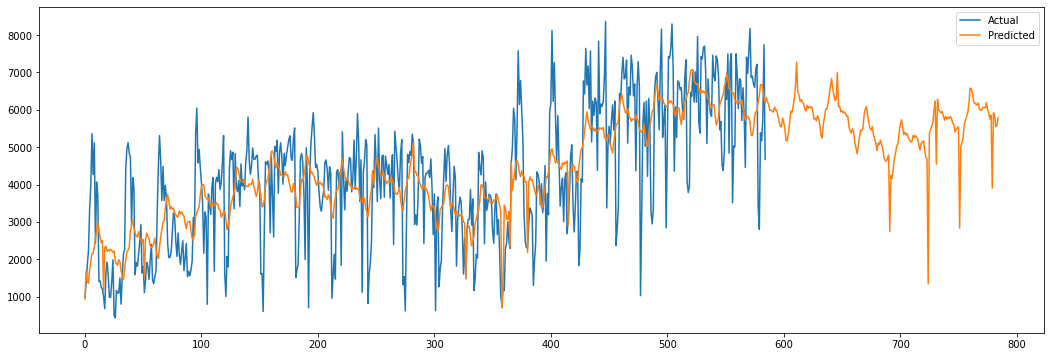

In [ ]:
predictivity = forecast['yhat'][:].values
Train = train['y'][:].values

# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(Train, label='Actual')
plt.plot(predictivity, label='Predicted')
plt.legend()
plt.show()


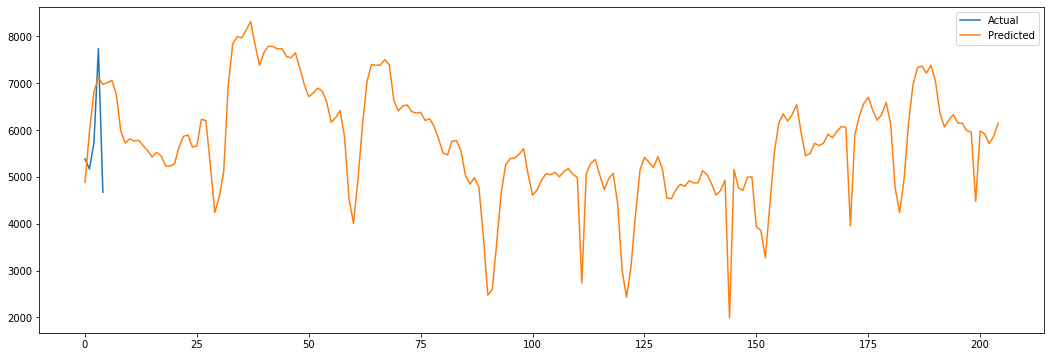

In [ ]:
predictivity = forecast['yhat'][580:].values
Train = train['y'][580:].values

# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(Train, label='Actual')
plt.plot(predictivity, label='Predicted')
plt.legend()
plt.show()

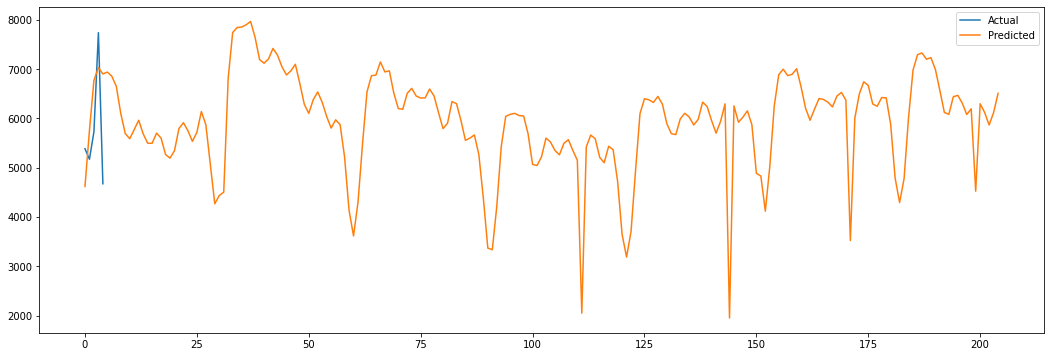

In [ ]:
predictivity = forecast['yhat'][580:].values
Train = train['y'][580:].values

# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(Train, label='Actual')
plt.plot(predictivity, label='Predicted')
plt.legend()
plt.show()

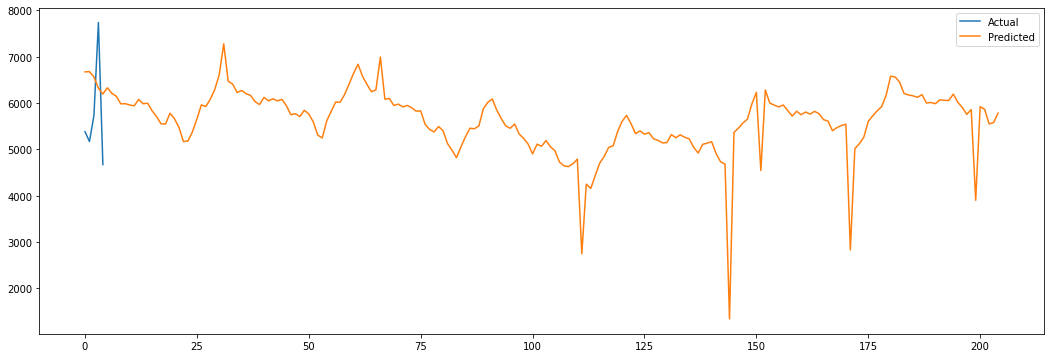

In [ ]:
predictivity = forecast['yhat'][580:].values
Train = train['y'][580:].values

# plot expected vs actual
fig = plt.figure(facecolor='w', figsize=(18, 6))
plt.plot(Train, label='Actual')
plt.plot(predictivity, label='Predicted')
plt.legend()
plt.show()